<a href="https://colab.research.google.com/github/wangjb/cwb_open_data/blob/master/fcst_GFS_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare environment for pygrib and installation

In [ ]:
!sudo apt-get update
!sudo apt-get -qq install python-cartopy python3-cartopy
!sudo pip uninstall shapely
!sudo pip install shapely --no-binary shapely
!sudo apt-get install python3-grib

### Retrieve CWB FCST grib data

In [1]:
import urllib
import requests

def retrieve_data(datacode,auth):
  # query string to CWB open data service
  url='https://opendata.cwb.gov.tw/'
  sub_path='fileapi/v1/opendataapi/'
  # instant 10 min precip
  datalimit=''
  dataoffset=''
  dataformat='JSON'
  stationID=''
  datastatus=''

  # create query string
  url_path=url+sub_path+datacode
  query_fields=['Authorization','limit','offset','format','stationID','status']
  query_data=(auth,datalimit,dataoffset,dataformat,stationID,datastatus)
  query_string=dict(zip(query_fields,query_data))

  # request data
  r = requests.get(url_path,params=query_string,stream=True)
  jsondata = r.json()

  return jsondata

In [2]:
datacode = 'M-A0060-024'
auth = None
jsondata = retrieve_data(datacode, auth)

In [3]:
import pandas as pd
jsondata['cwbopendata']['dataset']['datasetInfo']['parameterSet']

[{'parameterName': 'Resolution', 'parameterValue': '0.25 x 0.25 度'},
 {'parameterName': 'Grids', 'parameterValue': '1038240(1440*721)'},
 {'parameterName': 'Area', 'parameterValue': '全球'},
 {'parameterName': 'RunTime', 'parameterValue': '20200812 18Z'},
 {'parameterName': '預報時', 'parameterValue': '第024小時'},
 {'parameterName': '資料走向', 'parameterValue': '先橫軸西到東，再縱軸南到北'},
 {'parameterName': '資料起點',
  'parameterValue': '起點(1,1)位置為(0,-90)，終點(1440,721)位置為(359.25,-90)'}]

In [ ]:
import subprocess
dataURL = jsondata['cwbopendata']['dataset']['resource']['uri']
subprocess.run(["wget",datapath])

In [56]:
import pygrib as pb
import os
datapath = subprocess.check_output(["pwd"],stderr=subprocess.STDOUT,shell=True).decode('ascii').replace('\n','/') + os.path.basename(dataURL)
datapath
grbs = pb.open(datapath)

### Inventory of the grib file

In [177]:
grbs.select()

[1:Geopotential Height:gpm (instant):regular_ll:isobaricInhPa:level 1000.0 Pa:fcst time 24 hrs:from 202008121800,
 2:Temperature:K (instant):regular_ll:isobaricInhPa:level 1000.0 Pa:fcst time 24 hrs:from 202008121800,
 3:U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 1000.0 Pa:fcst time 24 hrs:from 202008121800,
 4:V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 1000.0 Pa:fcst time 24 hrs:from 202008121800,
 5:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 1000.0 Pa:fcst time 24 hrs:from 202008121800,
 6:Geopotential Height:gpm (instant):regular_ll:isobaricInhPa:level 2000.0 Pa:fcst time 24 hrs:from 202008121800,
 7:Temperature:K (instant):regular_ll:isobaricInhPa:level 2000.0 Pa:fcst time 24 hrs:from 202008121800,
 8:U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 2000.0 Pa:fcst time 24 hrs:from 202008121800,
 9:V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 2000.0 Pa:fcst time 24 hrs:f

### Plot GFS Surface Temp. data

In [175]:
surfaceTemp = grbs.select(name='Temperature',typeOfLevel='surface')[0]

nx = surfaceTemp['Ni']
ny = surfaceTemp['Nj']
lat = surfaceTemp["latitudes"].reshape(ny,nx)
lon = surfaceTemp["longitudes"].reshape(ny,nx)
surfaceTempData = surfaceTemp['values'] - 273.15

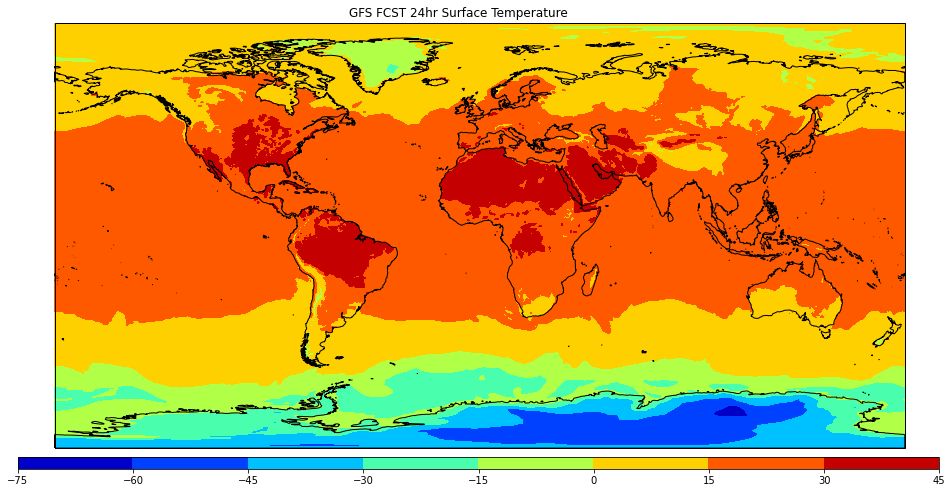

In [176]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

fig = plt.figure(figsize=(16,16))
axes = plt.axes(projection=ccrs.PlateCarree())

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

ctf = plt.contourf(lon,lat,surfaceTempData,cmap=plt.get_cmap('jet'))
axes.set_title("GFS FCST 24hr Surface Temperature")

cbaxes = fig.add_axes([0.13,0.3,0.8,0.01])
cbar = plt.colorbar(ctf,orientation="horizontal",cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()